In [1]:
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.dummy import DummyClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler

from joblib import dump, load

# Préparation dataset

In [2]:
# Import des données
df = pd.read_csv('data/merged_data_2018_2021_for_model.csv' )
df.shape

(423136, 34)

In [3]:
# Encodage des variables catégorielles
cat_var = df.select_dtypes(include='object').columns
encoded_cat = pd.get_dummies(df[cat_var], prefix=cat_var, drop_first=True).astype(int)
df = df.drop(columns=cat_var)
df = pd.concat([df, encoded_cat], axis=1)
print('Taille de dataset apres onehotconding',df.shape)


Taille de dataset apres onehotconding (423136, 51)


In [4]:
# Séparation de la variable cible et des variables explicatives
X = df.drop(['grav'], axis=1)
y = df['grav']

In [5]:
#  Division des données en ensemble d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101, stratify=y)

In [6]:
# Standardisation
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Création variable cible binaire

In [7]:
# Création variable cible binaire
y_bin = y.replace([1, 2], 0) \
         .replace([3, 4], 1)
y_train_bin = y_train.replace([1, 2], 0) \
                         .replace([3, 4], 1)
y_test_bin = y_test.replace([1, 2], 0) \
                        .replace([3, 4], 1)

# Undersampling

In [8]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=101)
X_train_underresampled, y_train_underresampled = rus.fit_resample(X_train_scaled, y_train)

# Dummy classifier 4 classes

In [9]:
# Test DummyClassifier pour comparaison
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_underresampled, y_train_underresampled)
y_pred_dum = dummy_clf.predict(X_test_scaled)
print(classification_report(y_test,y_pred_dum))

              precision    recall  f1-score   support

         1.0       0.42      1.00      0.60     17964
         2.0       0.00      0.00      0.00      1096
         3.0       0.00      0.00      0.00      6667
         4.0       0.00      0.00      0.00     16587

    accuracy                           0.42     42314
   macro avg       0.11      0.25      0.15     42314
weighted avg       0.18      0.42      0.25     42314



C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# KNN undersampling 4 classes

In [12]:
model =  KNeighborsClassifier(n_neighbors=4, metric='euclidean')
model.fit(X_train_underresampled, y_train_underresampled)

# train score
y_pred = model.predict(X_train_underresampled)
clsf_report = pd.DataFrame(classification_report(y_train_underresampled, y_pred, output_dict=True)).transpose()
clsf_report.to_csv('res/knn_4classes_undersamppling_euclidean_train.csv', index= True)
print(clsf_report)

# test score
y_pred= model.predict(X_test_scaled)
clsf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
clsf_report.to_csv('res/knn_4classes_undersamppling_euclidean_test.csv', index= True)
print(clsf_report)

# sauvegarde modèle
dump(model, 'model/knn_4classes_undersamppling_euclidean.joblib')

C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


              precision    recall  f1-score       support
1.0            0.646356  0.827642  0.725851   9869.000000
2.0            0.641876  0.752964  0.692996   9869.000000
3.0            0.623067  0.543013  0.580292   9869.000000
4.0            0.694190  0.468538  0.559468   9869.000000
accuracy       0.648039  0.648039  0.648039      0.648039
macro avg      0.651372  0.648039  0.639652  39476.000000
weighted avg   0.651372  0.648039  0.639652  39476.000000


C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


              precision    recall  f1-score      support
1.0            0.623109  0.649020  0.635801  17964.00000
2.0            0.082469  0.558394  0.143713   1096.00000
3.0            0.258085  0.311234  0.282179   6667.00000
4.0            0.534267  0.262254  0.351814  16587.00000
accuracy       0.441840  0.441840  0.441840      0.44184
macro avg      0.374482  0.445226  0.353376  42314.00000
weighted avg   0.516766  0.441840  0.456016  42314.00000


['model/knn_4classes_undersamppling_euclidean.joblib']

In [13]:
model =  KNeighborsClassifier(n_neighbors=4, metric='minkowski')
model.fit(X_train_underresampled, y_train_underresampled)

# train score
y_pred = model.predict(X_train_underresampled)
clsf_report = pd.DataFrame(classification_report(y_train_underresampled, y_pred, output_dict=True)).transpose()
clsf_report.to_csv('res/knn_4classes_undersamppling_minkowski_train.csv', index= True)
print(clsf_report)

# test score
y_pred= model.predict(X_test_scaled)
clsf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
clsf_report.to_csv('res/knn_4classes_undersamppling_minkowski_test.csv', index= True)
print(clsf_report)

# sauvegarde modèle
dump(model, 'model/knn_4classes_undersamppling_minkowski.joblib')

C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


              precision    recall  f1-score       support
1.0            0.646356  0.827642  0.725851   9869.000000
2.0            0.641876  0.752964  0.692996   9869.000000
3.0            0.623067  0.543013  0.580292   9869.000000
4.0            0.694190  0.468538  0.559468   9869.000000
accuracy       0.648039  0.648039  0.648039      0.648039
macro avg      0.651372  0.648039  0.639652  39476.000000
weighted avg   0.651372  0.648039  0.639652  39476.000000


C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


              precision    recall  f1-score      support
1.0            0.623109  0.649020  0.635801  17964.00000
2.0            0.082469  0.558394  0.143713   1096.00000
3.0            0.258085  0.311234  0.282179   6667.00000
4.0            0.534267  0.262254  0.351814  16587.00000
accuracy       0.441840  0.441840  0.441840      0.44184
macro avg      0.374482  0.445226  0.353376  42314.00000
weighted avg   0.516766  0.441840  0.456016  42314.00000


['model/knn_4classes_undersamppling_minkowski.joblib']

In [14]:
model =  KNeighborsClassifier(n_neighbors=4, metric='manhattan')
model.fit(X_train_underresampled, y_train_underresampled)

# train score
y_pred = model.predict(X_train_underresampled)
clsf_report = pd.DataFrame(classification_report(y_train_underresampled, y_pred, output_dict=True)).transpose()
clsf_report.to_csv('res/knn_4classes_undersamppling_manhattan_train.csv', index= True)
print(clsf_report)

# test score
y_pred= model.predict(X_test_scaled)
clsf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
clsf_report.to_csv('res/knn_4classes_undersamppling_manhattan_test.csv', index= True)
print(clsf_report)

# sauvegarde modèle
dump(model, 'model/knn_4classes_undersamppling_manhattan.joblib')

C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


              precision    recall  f1-score       support
1.0            0.663818  0.849934  0.745434   9869.000000
2.0            0.659061  0.763907  0.707622   9869.000000
3.0            0.631325  0.557503  0.592122   9869.000000
4.0            0.705504  0.477961  0.569858   9869.000000
accuracy       0.662326  0.662326  0.662326      0.662326
macro avg      0.664927  0.662326  0.653759  39476.000000
weighted avg   0.664927  0.662326  0.653759  39476.000000


C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


              precision    recall  f1-score       support
1.0            0.647950  0.697617  0.671867  17964.000000
2.0            0.093850  0.587591  0.161850   1096.000000
3.0            0.275875  0.327434  0.299451   6667.000000
4.0            0.552330  0.272985  0.365382  16587.000000
accuracy       0.469986  0.469986  0.469986      0.469986
macro avg      0.392501  0.471407  0.374638  42314.000000
weighted avg   0.537491  0.469986  0.479838  42314.000000


['model/knn_4classes_undersamppling_manhattan.joblib']

In [15]:
model =  KNeighborsClassifier(n_neighbors=4, metric='chebyshev')
model.fit(X_train_underresampled, y_train_underresampled)

# train score
y_pred = model.predict(X_train_underresampled)
clsf_report = pd.DataFrame(classification_report(y_train_underresampled, y_pred, output_dict=True)).transpose()
clsf_report.to_csv('res/knn_4classes_undersamppling_chebyshev_train.csv', index= True)
print(clsf_report)

# test score
y_pred= model.predict(X_test_scaled)
clsf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
clsf_report.to_csv('res/knn_4classes_undersamppling_chebyshev_test.csv', index= True)
print(clsf_report)

# sauvegarde modèle
dump(model, 'model/knn_4classes_undersamppling_chebyshev.joblib')

C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


              precision    recall  f1-score       support
1.0            0.601081  0.755294  0.669421   9869.000000
2.0            0.609797  0.702604  0.652919   9869.000000
3.0            0.595858  0.521836  0.556396   9869.000000
4.0            0.625124  0.447259  0.521441   9869.000000
accuracy       0.606748  0.606748  0.606748      0.606748
macro avg      0.607965  0.606748  0.600044  39476.000000
weighted avg   0.607965  0.606748  0.600044  39476.000000


C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


              precision    recall  f1-score       support
1.0            0.575531  0.535515  0.554803  17964.000000
2.0            0.064207  0.501825  0.113848   1096.000000
3.0            0.229799  0.289636  0.256271   6667.000000
4.0            0.470800  0.244951  0.322243  16587.000000
accuracy       0.382001  0.382001  0.382001      0.382001
macro avg      0.335084  0.392982  0.311791  42314.000000
weighted avg   0.466759  0.382001  0.405182  42314.000000


['model/knn_4classes_undersamppling_chebyshev.joblib']

# KNN undersampling 2 classes

In [21]:
from imblearn.under_sampling import RandomUnderSampler

ros = RandomUnderSampler(random_state=101)
X_train_underresampled_bin, y_train_underresampled_bin = ros.fit_resample(X_train_scaled, y_train_bin)

In [ ]:
model =  KNeighborsClassifier(n_neighbors=2, metric='euclidean')
model.fit(X_train_underresampled_bin, y_train_underresampled_bin)

# train score
y_pred = model.predict(X_train_underresampled_bin)
clsf_report = pd.DataFrame(classification_report(y_train_underresampled_bin, y_pred, output_dict=True)).transpose()
clsf_report.to_csv('res/knn_2classes_undersamppling_euclidean_train.csv', index= True)
print(clsf_report)

# test score
y_pred= model.predict(X_test_scaled)
clsf_report = pd.DataFrame(classification_report(y_test_bin, y_pred, output_dict=True)).transpose()
clsf_report.to_csv('res/knn_2classes_undersamppling_euclidean_test.csv', index= True)
print(clsf_report)

# sauvegarde modèle
dump(model, 'model/knn_2classes_undersamppling_euclidean.joblib')

In [2]:
import pandas as pd
print(pd.read_csv('res/knn_2classes_undersamppling_euclidean_train.csv'))
print(pd.read_csv('res/knn_2classes_undersamppling_euclidean_test.csv'))

     Unnamed: 0  precision    recall  f1-score        support
0           0.0   0.737456  1.000000  0.848892  171539.000000
1           1.0   1.000000  0.643988  0.783446  171539.000000
2      accuracy   0.821994  0.821994  0.821994       0.821994
3     macro avg   0.868728  0.821994  0.816169  343078.000000
4  weighted avg   0.868728  0.821994  0.816169  343078.000000
     Unnamed: 0  precision    recall  f1-score       support
0           0.0   0.563945  0.849528  0.677887  19060.000000
1           1.0   0.789149  0.461598  0.582483  23254.000000
2      accuracy   0.636338  0.636338  0.636338      0.636338
3     macro avg   0.676547  0.655563  0.630185  42314.000000
4  weighted avg   0.687708  0.636338  0.625457  42314.000000


In [ ]:
model =  KNeighborsClassifier(n_neighbors=2, metric='minkowski')
model.fit(X_train_underresampled_bin, y_train_underresampled_bin)

# train score
y_pred = model.predict(X_train_underresampled_bin)
clsf_report = pd.DataFrame(classification_report(y_train_underresampled_bin, y_pred, output_dict=True)).transpose()
clsf_report.to_csv('res/knn_2classes_undersamppling_minkowski_train.csv', index= True)
print(clsf_report)

# test score
y_pred= model.predict(X_test_scaled)
clsf_report = pd.DataFrame(classification_report(y_test_bin, y_pred, output_dict=True)).transpose()
clsf_report.to_csv('res/knn_2classes_undersamppling_minkowski_test.csv', index= True)
print(clsf_report)

# sauvegarde modèle
dump(model, 'model/knn_2classes_undersamppling_minkowski.joblib')

In [4]:
import pandas as pd
print(pd.read_csv('res/knn_2classes_undersamppling_minkowski_train.csv'))
print(pd.read_csv('res/knn_2classes_undersamppling_minkowski_test.csv'))

     Unnamed: 0  precision    recall  f1-score        support
0           0.0   0.737456  1.000000  0.848892  171539.000000
1           1.0   1.000000  0.643988  0.783446  171539.000000
2      accuracy   0.821994  0.821994  0.821994       0.821994
3     macro avg   0.868728  0.821994  0.816169  343078.000000
4  weighted avg   0.868728  0.821994  0.816169  343078.000000
     Unnamed: 0  precision    recall  f1-score       support
0           0.0   0.563945  0.849528  0.677887  19060.000000
1           1.0   0.789149  0.461598  0.582483  23254.000000
2      accuracy   0.636338  0.636338  0.636338      0.636338
3     macro avg   0.676547  0.655563  0.630185  42314.000000
4  weighted avg   0.687708  0.636338  0.625457  42314.000000


In [ ]:
model =  KNeighborsClassifier(n_neighbors=2, metric='manhattan')
model.fit(X_train_underresampled_bin, y_train_underresampled_bin)

# train score
y_pred = model.predict(X_train_underresampled_bin)
clsf_report = pd.DataFrame(classification_report(y_train_underresampled_bin, y_pred, output_dict=True)).transpose()
clsf_report.to_csv('res/knn_2classes_undersamppling_manhattan_train.csv', index= True)
print(clsf_report)

# test score
y_pred= model.predict(X_test_scaled)
clsf_report = pd.DataFrame(classification_report(y_test_bin, y_pred, output_dict=True)).transpose()
clsf_report.to_csv('res/knn_2classes_undersamppling_manhattan_test.csv', index= True)
print(clsf_report)

# sauvegarde modèle
dump(model, 'model/knn_2classes_undersamppling_manhattan.joblib')

In [5]:
import pandas as pd
print(pd.read_csv('res/knn_2classes_undersamppling_manhattan_train.csv'))
print(pd.read_csv('res/knn_2classes_undersamppling_manhattan_test.csv'))

     Unnamed: 0  precision    recall  f1-score        support
0           0.0   0.744828  1.000000  0.853755  171539.000000
1           1.0   1.000000  0.657407  0.793296  171539.000000
2      accuracy   0.828704  0.828704  0.828704       0.828704
3     macro avg   0.872414  0.828704  0.823525  343078.000000
4  weighted avg   0.872414  0.828704  0.823525  343078.000000
     Unnamed: 0  precision    recall  f1-score       support
0           0.0   0.576748  0.862277  0.691185  19060.000000
1           1.0   0.810030  0.481337  0.603852  23254.000000
2      accuracy   0.652928  0.652928  0.652928      0.652928
3     macro avg   0.693389  0.671807  0.647519  42314.000000
4  weighted avg   0.704950  0.652928  0.643190  42314.000000


In [ ]:
model =  KNeighborsClassifier(n_neighbors=2, metric='chebyshev')
model.fit(X_train_underresampled_bin, y_train_underresampled_bin)

# train score
y_pred = model.predict(X_train_underresampled_bin)
clsf_report = pd.DataFrame(classification_report(y_train_underresampled_bin, y_pred, output_dict=True)).transpose()
clsf_report.to_csv('res/knn_2classes_undersamppling_chebyshev_train.csv', index= True)
print(clsf_report)

# test score
y_pred= model.predict(X_test_scaled)
clsf_report = pd.DataFrame(classification_report(y_test_bin, y_pred, output_dict=True)).transpose()
clsf_report.to_csv('res/knn_2classes_undersamppling_chebyshev_test.csv', index= True)
print(clsf_report)

# sauvegarde modèle
dump(model, 'model/knn_2classes_undersamppling_chebyshev.joblib')

In [6]:
import pandas as pd
print(pd.read_csv('res/knn_2classes_undersamppling_chebyshev_train.csv'))
print(pd.read_csv('res/knn_2classes_undersamppling_chebyshev_test.csv'))

     Unnamed: 0  precision    recall  f1-score        support
0           0.0   0.681086  1.000000  0.810293  171539.000000
1           1.0   1.000000  0.531757  0.694310  171539.000000
2      accuracy   0.765878  0.765878  0.765878       0.765878
3     macro avg   0.840543  0.765878  0.752301  343078.000000
4  weighted avg   0.840543  0.765878  0.752301  343078.000000
     Unnamed: 0  precision    recall  f1-score       support
0           0.0   0.514969  0.861857  0.644714  19060.000000
1           1.0   0.747192  0.334652  0.462265  23254.000000
2      accuracy   0.572127  0.572127  0.572127      0.572127
3     macro avg   0.631080  0.598255  0.553490  42314.000000
4  weighted avg   0.642589  0.572127  0.544448  42314.000000


# KNN Best model avec undersampling (4 classes)

In [18]:
param_grid = {'n_neighbors': np.arange(1, 20),
              'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

In [ ]:
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid, cv=5)
grid.fit(X_train_underresampled, y_train_underresampled)

print(grid.best_score_)
print(grid.best_params_)
dump(grid, 'knn_bestmodel_4classes_undersamping.joblib')

In [15]:
model= load('model/knn_bestmodel_4classes_undersamping.joblib')
print(model.best_params_)
print('Accuracy train: ', model.score(X_train_underresampled, y_train_underresampled))
print('Accuracy test: ', model.score(X_test_scaled, y_test))

{'metric': 'manhattan', 'n_neighbors': 18, 'weights': 'distance'}
Accuracy train:  0.999316040125646
Accuracy test:  0.5117455215767831


# KNN Best model avec undersampling (2 classes)

In [24]:
model = KNeighborsClassifier()
model = GridSearchCV(model, param_grid)

model.fit(X_train_underresampled_bin, y_train_underresampled_bin)
print(model.best_score_)
print(model.best_params_)

print('Accuracy train: ', model.score(X_train_underresampled_bin, y_train_underresampled_bin))
print('Accuracy test: ', model.score(X_test_scaled, y_test_bin))
dump(model, 'knn_bestmodel_2classes_undersamping.joblib')

C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

0.7405400512536
{'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}
Accuracy train:  0.9973766898489557
Accuracy test:  0.739447936853051


['knn_bestmodel_2classes_undersamping.joblib']

# KNN Best model avec undersampling (2 classes) => test sur dico réduit à juste k entre 1 et 10

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve, RandomizedSearchCV

C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\juliette.brezillon\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

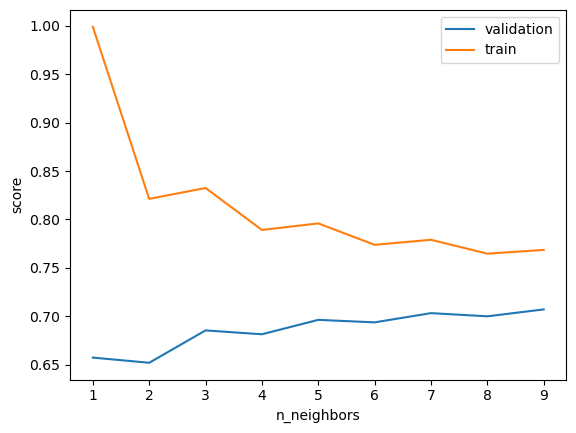

In [18]:
model_1 = KNeighborsClassifier(n_neighbors = 4)
model_1.fit(X_train_underresampled_bin, y_train_underresampled_bin)

k_1 = np.arange(1, 10)
train_score_1, val_score_1 = validation_curve(model_1, 
                                              X_train_underresampled_bin,
                                              y_train_underresampled_bin, 
                                               param_name="n_neighbors",
                                              param_range=k_1, cv = 5,
                                             scoring="accuracy")

plt.plot(k_1, val_score_1.mean(axis = 1), label = 'validation')
plt.plot(k_1, train_score_1.mean(axis = 1), label = 'train')

plt.ylabel('score')
plt.xlabel('n_neighbors')